Информация должна быть тут

In [ ]:
import os
import zipfile
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
from torchvision.io import read_image
sns.set(style='darkgrid', font_scale=1.2)
from torch.utils.data import Dataset
from torchvision import datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
zip_file = '/content/drive/MyDrive/ОбучениеML/Практика/Датасеты/faces_dataset_small.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()
os.remove('/content/faces_dataset_small/04000/.DS_Store')
os.remove('/content/faces_dataset_small/.DS_Store')
os.rmdir('/content/faces_dataset_small/04000')

Mounted at /content/drive


In [ ]:
transform=tt.Compose([
    tt.Resize(64),
    tt.ToTensor(),
    #tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
from PIL import Image
from torch.utils.data import Dataset
from natsort import natsorted
from torchvision import datasets, transforms
 
# Define your own class LoadFromFolder
class LoadFromFolder(Dataset):
    def __init__(self, main_dir, transform):
         
        # Set the loading directory
        self.main_dir = main_dir
        self.transform = transform
         
        # List all images in folder and count them
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)
    def __len__(self):
        # Return the previously computed number of images
        return len(self.total_imgs)
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
     
        # Use PIL for image loading
        image = Image.open(img_loc).convert("RGB")
        # Apply the transformations
        tensor_image = self.transform(image)
        return tensor_image

In [ ]:
train_data = LoadFromFolder('/content/faces_dataset_small', transform = transform)
train_loader = DataLoader(train_data, batch_size = 128, shuffle=True, num_workers=2, pin_memory=True)

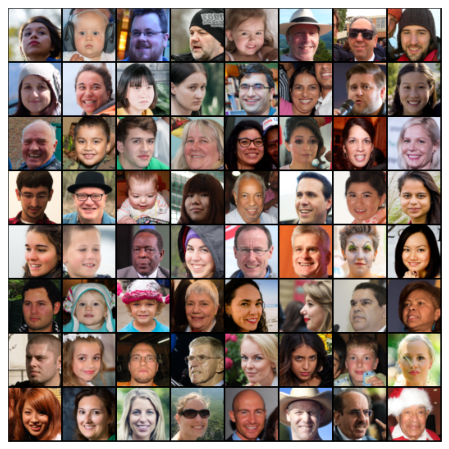

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break
show_batch(train_loader)

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.cpu().detach()[:nmax], nrow=8).permute(1, 2, 0))

Построение модели

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, d=64, dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim, d, 4, 2, 1),
            nn.InstanceNorm2d(d),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d, d * 2, 4, 2, 1),
            nn.InstanceNorm2d(d * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d * 2, d * 4, 4, 2, 1),
            nn.InstanceNorm2d(d * 4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d * 4, d * 8, 4, 2, 1),
            nn.InstanceNorm2d(d * 8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d * 8, 1, 4, 1, 0),
        )

    def forward(self, x):
        outputs = self.net(x)
        return outputs.squeeze()     

In [ ]:
class Generator(nn.Module):
  def __init__(self, latent_size=128, z=64):
    super().__init__()
    self.model = nn.Sequential(
        nn.ConvTranspose2d(latent_size, z*8, 4, 1, 0),
        nn.BatchNorm2d(z*8),
        nn.ReLU(True),

        nn.ConvTranspose2d(z*8, z*4, 4, 2, 1),
        nn.BatchNorm2d(z*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(z*4, z*2, 4, 2, 1),
        nn.BatchNorm2d(z*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(z*2, z, 4, 2, 1),
        nn.BatchNorm2d(z),
        nn.ReLU(True),

        nn.ConvTranspose2d(z, 3, 4, 2, 1),
        nn.Tanh()
    )
  def forward(self, x):
    return self.model(x)

WGAN-GP

In [ ]:
import imageio
import numpy as np
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch import autograd

In [ ]:
class WGAN_GP():
    def __init__(self, gen, critic, gen_opt, critic_opt,device,latent_shape, n_critic=5):
        self.gen = gen
        self.latent_shape = latent_shape
        self.critic = critic
        self.gen_opt = gen_opt
        self.critic_opt = critic_opt
        self.steps = 0
        self.n_critic = n_critic

    def train(self, data_loader, num_epochs):
        for i in range(num_epochs):
            self.train_epoch(data_loader)

    def train_epoch(self, data_loader):
        for data in tqdm(data_loader):
            self.steps += 1
            data = Variable(data)
            data = data.to(device)
            d_loss, grad_penalty = self.critic_train_step(data)
            if self.steps % self.n_critic == 0:
                g_loss = self.gen_train_step(data.size(0))
        show_images(self.sampler(1), 1)
        print('    g_loss: {:.3f} d_loss: {:.3f} grad_penalty: {:.3f}'.format(g_loss, d_loss, grad_penalty))

    def critic_train_step(self, data):
        batch_size = data.size(0)
        generated_data = self.sampler(batch_size)
        #interpolation_logits = self.critic(data)####
        grad_penalty = self.gradient_penalty(data, generated_data)
        d_loss = self.critic(generated_data).mean() - self.critic(data).mean() + grad_penalty
        self.critic_opt.zero_grad()
        d_loss.backward()
        self.critic_opt.step()
        return d_loss.item(), grad_penalty.item()
        
    def gen_train_step(self, batch_size):
        self.gen_opt.zero_grad()
        generated_data = self.sampler(batch_size)
        g_loss = -self.critic(generated_data).mean()
        g_loss.backward()
        self.gen_opt.step()
        return g_loss.item()

    def gradient_penalty(self, data, generated_data, gamma=10):
        batch_size = data.size(0)
        epsilon = torch.rand(batch_size, 1, 1, 1)
        epsilon = epsilon.expand_as(data).to(device)

        interpolation = epsilon * data.data + (1 - epsilon) * generated_data.data
        interpolation = Variable(interpolation, requires_grad=True).to(device)
        #print(interpolation.dtype, data.dtype)########################################################
        interpolation_logits = self.critic(interpolation)
        #print(interpolation.shape, data.shape)##
        grad_outputs = torch.ones(interpolation_logits.size()).to(device)

        gradients = autograd.grad(outputs=interpolation_logits,
                                  inputs=interpolation,
                                  grad_outputs=grad_outputs,
                                  create_graph=True,
                                  retain_graph=True)[0]

        gradients = gradients.view(batch_size, -1)
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
        return gamma * ((gradients_norm - 1) ** 2).mean()
      
    def sampler(self, n_samples):
        z = Variable(torch.randn(n_samples, *self.latent_shape))
        return self.gen(z.to(device))

Обучение

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
generator = Generator().to(device) 
discriminator = Discriminator().to(device) 

In [ ]:
lr = 1e-4
gen_opt = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
critic_opt = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))

In [ ]:
model = WGAN_GP(generator, discriminator, gen_opt, critic_opt,device, latent_shape = [128, 1, 1] , n_critic=5)

  0%|          | 0/25 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    g_loss: 19.128 d_loss: -8.684 grad_penalty: 1.529


  0%|          | 0/25 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    g_loss: 24.412 d_loss: -8.604 grad_penalty: 2.318


  0%|          | 0/25 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    g_loss: 22.952 d_loss: -8.513 grad_penalty: 1.475


  0%|          | 0/25 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    g_loss: 20.909 d_loss: -8.456 grad_penalty: 3.542


  0%|          | 0/25 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    g_loss: 23.082 d_loss: -8.107 grad_penalty: 2.931


  0%|          | 0/25 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    g_loss: 22.060 d_loss: -8.523 grad_penalty: 1.720


  0%|          | 0/25 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    g_loss: 22.697 d_loss: -7.998 grad_penalty: 3.127


  0%|          | 0/25 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    g_loss: 24.966 d_loss: -8.753 grad_penalty: 1.229


  0%|          | 0/25 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    g_loss: 23.775 d_loss: -7.691 grad_penalty: 2.104


  0%|          | 0/25 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    g_loss: 22.667 d_loss: -8.399 grad_penalty: 2.407


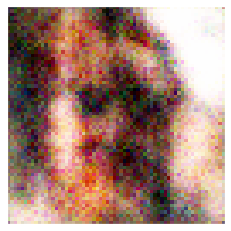

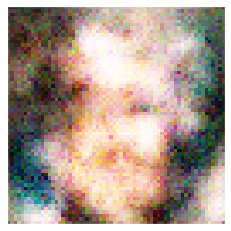

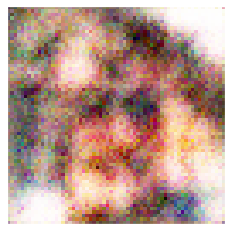

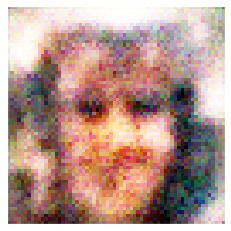

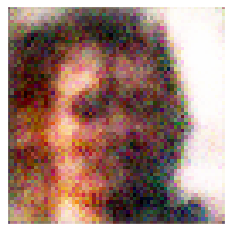

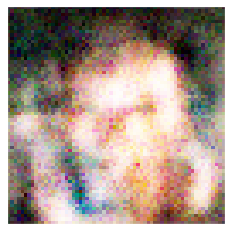

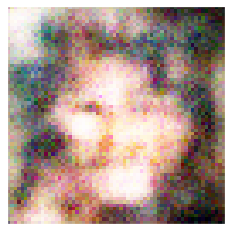

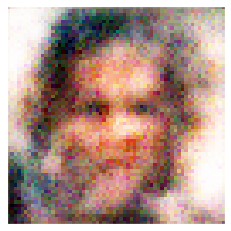

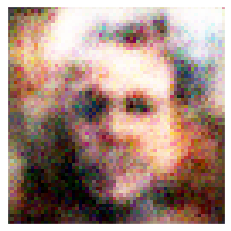

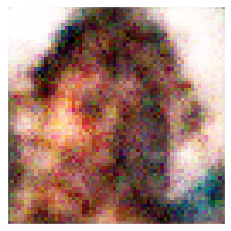

In [ ]:
model.train(train_loader, 10)

In [ ]:
img = model.sampler(64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


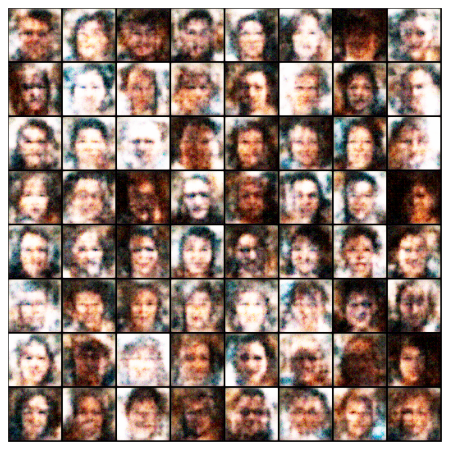

In [ ]:
show_images(img, 64)

In [ ]:
torch.save(model, '/content/wgan_gp')

PicklingError: ignored

In [ ]:
from google.colab import files
files.download('/content/d')
files.download('/content/g')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>